In [1]:
import numpy as np
from minigrid.core.constants import COLOR_NAMES
from minigrid.core.grid import Grid
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Wall
from minigrid.manual_control import ManualControl
from minigrid.minigrid_env import MiniGridEnv

pygame 2.6.0 (SDL 2.28.4, Python 3.8.19)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class SimpleEnv(MiniGridEnv):
    def __init__(
        self,
        size=10,
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        max_steps: int or None = None,
        **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir

        mission_space = MissionSpace(mission_func=self._gen_mission)

        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            # Set this to True for maximum speed
            see_through_walls=True,
            max_steps=max_steps,
            **kwargs,
        )

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Generate vertical separation wall
        for i in range(0, height):
            self.grid.set(5, i, Wall())
        
        # Place the door and key
        self.grid.set(5, 6, Door(COLOR_NAMES[0], is_locked=True))
        self.grid.set(3, 6, Key(COLOR_NAMES[0]))

        # Place a goal square in the bottom-right corner
        self.put_obj(Goal(), width - 2, height - 2)

        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "grand mission"


In [3]:
# "left": Actions.left,
# "right": Actions.right,
# "up": Actions.forward,
# "space": Actions.toggle,
# "pageup": Actions.pickup,
# "pagedown": Actions.drop,
# "tab": Actions.pickup,
# "left shift": Actions.drop,
# "enter": Actions.done,

env = SimpleEnv(render_mode="human")

# enable manual control for testing
manual_control = ManualControl(env, seed=42)
# manual_control.start()

In [4]:
import gymnasium as gym
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import torch
import torch.nn as nn

In [5]:
class MinigridFeaturesExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.Space, features_dim: int = 512, normalized_image: bool = False) -> None:
        super().__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 16, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with torch.no_grad():
            n_flatten = self.cnn(torch.as_tensor(observation_space.sample()[None]).float()).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(observations))

In [6]:
from minigrid.wrappers import ImgObsWrapper
from stable_baselines3 import PPO

In [7]:
policy_kwargs = dict(
    features_extractor_class=MinigridFeaturesExtractor,
    features_extractor_kwargs=dict(features_dim=128),
)

env = SimpleEnv(render_mode="rgb_array")
env = ImgObsWrapper(env)

model = PPO("CnnPolicy", env, policy_kwargs=policy_kwargs, verbose=1)
model.learn(1e3)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 400      |
|    ep_rew_mean     | 0        |
| time/              |          |
|    fps             | 376      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------


In [8]:
import matplotlib.pyplot as plt
from minigrid.wrappers import FullyObsWrapper

In [9]:
# Create and wrap the environment
env = SimpleEnv(render_mode=None)
env = FullyObsWrapper(env)  # Wrap the environment to get fully observable state

# Reset the environment
obs = env.reset()

# Run a loop with random actions and print the observation
done = False
step_count = 0

while not done:
    # Select a random action
    action = env.action_space.sample()
    
    # Perform the action
    obs, reward, done, truncated, info = env.step(action)
    
    # Extract the image from the observation
    image = obs['image']  # (grid_size, grid_size, 3)
    
    # Print the image content and format
    print(f"Step: {step_count}")
    print(f"Image shape: {image.shape}")
    
    # Print the grid with each layer separately
    # Channel 0: Object types
    print("Object Types (Channel 0):")
    print(image[:, :, 0].transpose(1, 0))

    # Channel 1: Colors
    print("Colors (Channel 1):")
    print(image[:, :, 1].transpose(1, 0))

    # Channel 2: Additional State
    print("Additional State (Channel 2):")
    print(image[:, :, 2].transpose(1, 0))
    
    direction = obs['direction']
    mission = obs['mission']

    # Print the direction and mission
    print(f"Direction: {direction}")
    print(f"Mission: {mission}")

    step_count += 1

    # Limit the number of steps to avoid infinite loops
    if step_count > 5:
        break

# Close the environment
env.close()

Step: 0
Image shape: (10, 10, 3)
Object Types (Channel 0):
[[ 2  2  2  2  2  2  2  2  2  2]
 [ 2  1  1  1  1  1  1  1  1  2]
 [ 2 10  1  1  1  1  1  1  1  2]
 [ 2  1  1  1  1  1  5  1  1  2]
 [ 2  1  1  1  1  1  1  1  1  2]
 [ 2  2  2  2  2  2  4  2  2  2]
 [ 2  1  1  1  1  1  1  1  1  2]
 [ 2  1  1  1  1  1  1  1  1  2]
 [ 2  1  1  1  1  1  1  1  8  2]
 [ 2  2  2  2  2  2  2  2  2  2]]
Colors (Channel 1):
[[5 5 5 5 5 5 5 5 5 5]
 [5 0 0 0 0 0 0 0 0 5]
 [5 0 0 0 0 0 0 0 0 5]
 [5 0 0 0 0 0 2 0 0 5]
 [5 0 0 0 0 0 0 0 0 5]
 [5 5 5 5 5 5 2 5 5 5]
 [5 0 0 0 0 0 0 0 0 5]
 [5 0 0 0 0 0 0 0 0 5]
 [5 0 0 0 0 0 0 0 1 5]
 [5 5 5 5 5 5 5 5 5 5]]
Additional State (Channel 2):
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Direction: 0
Mission: grand mission
Step: 1
Image shape: (10, 10, 3)
Object Types (Channel 0):
[[ 

{'image': array([[[ 2,  5,  0],
        [ 2,  5,  0],
        [ 2,  5,  0],
        [ 2,  5,  0],
        [ 2,  5,  0],
        [ 2,  5,  0],
        [ 2,  5,  0],
        [ 2,  5,  0],
        [ 2,  5,  0],
        [ 2,  5,  0]],

       [[ 2,  5,  0],
        [10,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 2,  5,  0]],

       [[ 2,  5,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 2,  5,  0]],

       [[ 2,  5,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 5,  2,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 2,  5,  0]],

       [[ 2,  5,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  

TypeError: Invalid shape (10, 3, 10) for image data

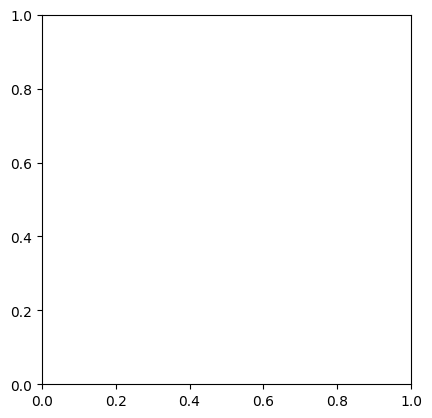

In [12]:
import matplotlib.pyplot as plt
from minigrid.wrappers import FullyObsWrapper

# Create and wrap the environment
env = SimpleEnv(render_mode=None)
env = FullyObsWrapper(env)  # Wrap the environment to get fully observable state

# Reset the environment
obs, _ = env.reset()

print(obs)

# Function to display the environment and get manual input
def display_and_get_action(image):
    plt.imshow(image)
    plt.title("Click on the plot to move: left, right, up, down")
    plt.axis('off')
    plt.show()
    print("Click on the plot to move: left, right, up, down")
    clicks = plt.ginput(1)
    plt.close()

    if not clicks:
        return env.action_space.sample()  # If no click, do random action

    x, y = clicks[0]
    if x < image.shape[1] / 4:
        return 0  # Left
    elif x > 3 * image.shape[1] / 4:
        return 1  # Right
    elif y < image.shape[0] / 4:
        return 2  # Up
    else:
        return 3  # Down

# Run a loop with manual actions
done = False
step_count = 0

while not done:
    # Display the image and get manual action
    image = np.transpose(obs['image'], (1, 2, 0))  # Transpose the image for display
    action = display_and_get_action(image)

    # Perform the action
    obs, reward, done, truncated, info = env.step(action)

    # Print the image content and format
    print(f"Step: {step_count}")
    print(f"Image shape: {image.shape}")

    # Print the grid with each layer separately
    # Channel 0: Object types
    print("Object Types (Channel 0):")
    print(obs['image'][:, :, 0])

    # Channel 1: Colors
    print("Colors (Channel 1):")
    print(obs['image'][:, :, 1])

    # Channel 2: Additional State
    print("Additional State (Channel 2):")
    print(obs['image'][:, :, 2])
    
    direction = obs['direction']
    mission = obs['mission']

    # Print the direction and mission
    print(f"Direction: {direction}")
    print(f"Mission: {mission}")

    step_count += 1

    # Limit the number of steps to avoid infinite loops
    if step_count > 5:
        break

# Close the environment
env.close()